<a href="https://colab.research.google.com/github/HackyRoot/SeeFood/blob/master/SeeFood_(Transfer_Learning).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SeeFood

## Import packages

In [1]:
import tensorflow as tf

tf.__version__

'2.2.0'

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import BinaryCrossentropy

## Load data

Source: https://www.kaggle.com/dansbecker/hot-dog-not-hot-dog

In [4]:
!rm data.zip* && rm -r data/
!wget https://raw.githubusercontent.com/HackyRoot/SeeFood/master/data.zip
!unzip data.zip
!ls

rm: cannot remove 'data.zip*': No such file or directory
--2020-06-14 15:23:25--  https://raw.githubusercontent.com/HackyRoot/SeeFood/master/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46841867 (45M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  44.67M  82.0MB/s    in 0.5s    

2020-06-14 15:23:27 (82.0 MB/s) - ‘data.zip’ saved [46841867/46841867]

Archive:  data.zip
   creating: data/
   creating: data/val/
   creating: data/val/hot_dog/
  inflating: data/val/hot_dog/527633.jpg  
  inflating: data/val/hot_dog/528022.jpg  
  inflating: data/val/hot_dog/530316.jpg  
  inflating: data/val/hot_dog/531567.jpg  
  inflating: data/val/hot_dog/533172.jpg  
  inflating: data/val/hot_dog/533521.jpg  
  inflating: dat

In [0]:
PATH = os.path.join('/content/data')
train_dir = os.path.join(PATH, 'train')
val_dir = os.path.join(PATH, 'val')

In [0]:
train_hotdog_dir = os.path.join(train_dir, 'hot_dog')
train_not_hotdog_dir = os.path.join(train_dir, 'not_hot_dog')

val_hotdog_dir = os.path.join(val_dir, 'hot_dog')
val_not_hotdog_dir = os.path.join(val_dir, 'not_hot_dog')

## Understand the data

In [0]:
num_hotdog_train = len(os.listdir(train_hotdog_dir))
num_not_hotdog_train = len(os.listdir(train_not_hotdog_dir))

num_hotdog_val = len(os.listdir(val_hotdog_dir))
num_not_hotdog_val = len(os.listdir(val_not_hotdog_dir))

total_train = num_hotdog_train + num_not_hotdog_train
total_val = num_hotdog_val + num_not_hotdog_val

In [8]:
print('total training hotdog images: ', num_hotdog_train)
print('total traning not hotdog images: ', num_not_hotdog_train)

print('total validation hotdog images: ', num_hotdog_val)
print('total validation not hotdog images: ', num_not_hotdog_val)

print('------------------------------------')

print('total training images: ', total_train)
print('total validation images: ', total_val)

total training hotdog images:  397
total traning not hotdog images:  397
total validation hotdog images:  101
total validation not hotdog images:  102
------------------------------------
total training images:  794
total validation images:  203


## Data preparation

In [0]:
batch_size = 40
epochs = 15
IMG_SIZE = 224
steps_per_epoch = 4
validation_steps = 10

In [0]:
train_image_generator = ImageDataGenerator(rescale=1/255,
                                           rotation_range = 40,
                                           height_shift_range = 0.2,
                                           width_shift_range = 0.2,
                                           shear_range = 0.2,
                                           zoom_range = 0.2,
                                           horizontal_flip = True,
                                           fill_mode='nearest')

val_image_generator = ImageDataGenerator(rescale=1/255)

In [11]:
train_data_gen = train_image_generator.flow_from_directory(train_dir,
                                                           batch_size=batch_size,
                                                           target_size=(IMG_SIZE, IMG_SIZE),
                                                           class_mode='binary')

val_data_gen = val_image_generator.flow_from_directory(val_dir,
                                                       batch_size=batch_size,
                                                       target_size=(IMG_SIZE, IMG_SIZE),
                                                       class_mode='binary')

Found 794 images belonging to 2 classes.
Found 203 images belonging to 2 classes.


## Visualize training images

In [0]:
sample_training_images, _ = next(train_data_gen)

In [0]:
def plotImages(images_arr):
  fig, axes = plt.subplots(1, 5, figsize=(20, 20))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()

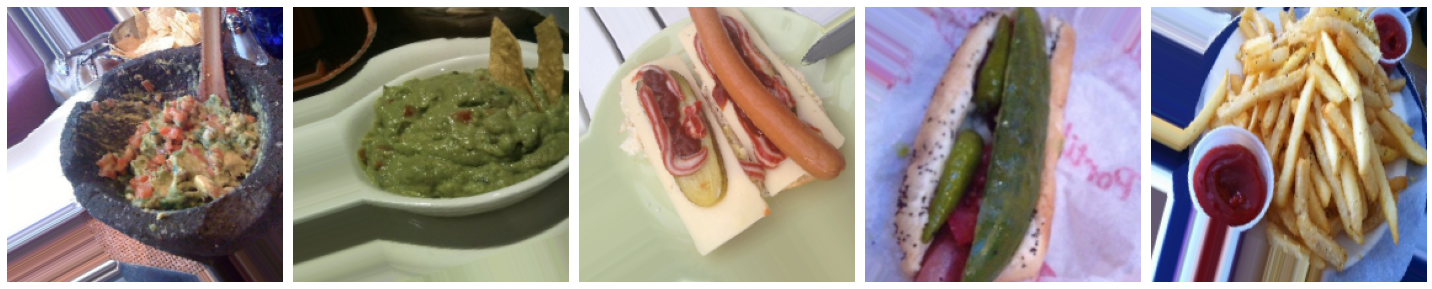

In [14]:
plotImages(sample_training_images[:5])

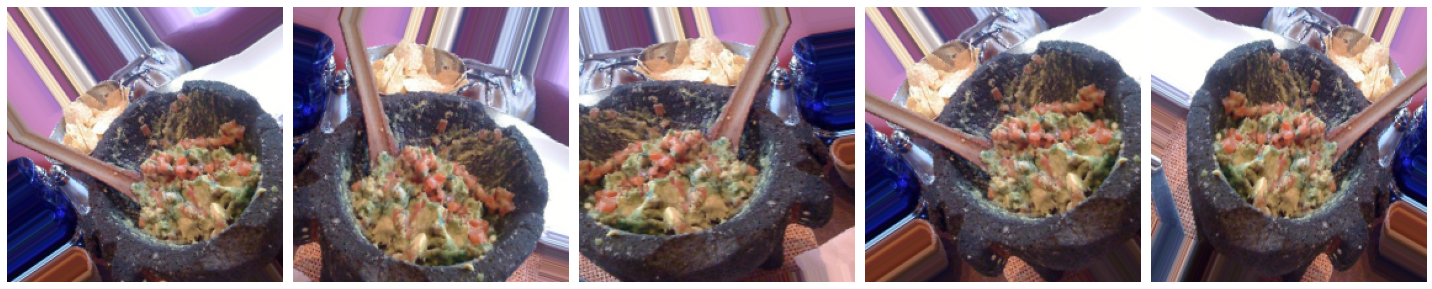

In [15]:
# visualize augmented images

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

## Create the base model from the pre-trained convnets

In [0]:
import tensorflow_hub as hub

In [17]:
for image_batch, label_batch in train_data_gen:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (40, 224, 224, 3)
Label batch shape:  (40,)


In [0]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" 

In [0]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE)

classifier = tf.keras.Sequential([
  hub.KerasLayer(classifier_url, input_shape=IMG_SHAPE+(3,))
])

In [0]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" 

In [0]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=IMG_SHAPE+(3,))

In [22]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(40, 1280)


In [0]:
feature_extractor_layer.trainable = False

In [24]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  Dense(1, activation='sigmoid')                             
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [26]:
history = model.fit(train_data_gen, 
                    epochs=15,
                    validation_data = val_data_gen)

Epoch 1/15
20/20 [==============================] - 12s 584ms/step - loss: 0.6677 - accuracy: 0.6083 - val_loss: 0.6130 - val_accuracy: 0.8177
Epoch 2/15
20/20 [==============================] - 11s 552ms/step - loss: 0.6082 - accuracy: 0.8388 - val_loss: 0.5803 - val_accuracy: 0.8768
Epoch 3/15
20/20 [==============================] - 11s 548ms/step - loss: 0.5862 - accuracy: 0.8627 - val_loss: 0.5675 - val_accuracy: 0.9064
Epoch 4/15
20/20 [==============================] - 11s 548ms/step - loss: 0.5785 - accuracy: 0.8652 - val_loss: 0.5620 - val_accuracy: 0.9064
Epoch 5/15
20/20 [==============================] - 11s 549ms/step - loss: 0.5682 - accuracy: 0.9018 - val_loss: 0.5565 - val_accuracy: 0.9015
Epoch 6/15
20/20 [==============================] - 11s 543ms/step - loss: 0.5659 - accuracy: 0.8942 - val_loss: 0.5544 - val_accuracy: 0.9113
Epoch 7/15
20/20 [==============================] - 11s 553ms/step - loss: 0.5644 - accuracy: 0.8980 - val_loss: 0.5521 - val_accuracy: 0.9163

In [0]:
model.save('seefood.h5')